In [4]:
# Forecast Competitor's Sales

# Import Libraries for data wrangling and machine learning 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Iterable
import itertools
import seaborn as sns
from sklearn.utils import indexable
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import random
from keras.models import Sequential
from sklearn.utils import shuffle
from keras.layers import Dense
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler
from graphviz import *
from copy import *
import datetime
from datetime import date, timedelta, datetime
from sklearn.metrics import r2_score, mean_squared_error,  mean_absolute_error, median_absolute_error
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
#%matplotlib inline 
## Run at end of script
#conn.close()


# Load Holiday Data

# Load Holiday Data
df0 = pd.read_excel('C:/Users/e351722/OneDrive - EDP/REN_prediction/holidays_ES.xlsx', sheet_name='Sheet1', converters={'Unnamed1':str, 
                                                                                        'Date':str,
                                                                                        'Weekday':str,
                                                                                        'Holiday':str,
                                                                                        'Holiday_type':str,
                                                                            
                                                                                        'Unnamed2':str})
df0 = df0.dropna()


df0['date'] = pd.DatetimeIndex(df0['Date'])
df0['dayofweek'] = df0['date'].apply(lambda x: x.dayofweek)
df0['dayofyear'] = df0['date'].apply(lambda x: x.dayofyear)



# Load Data
df = pd.read_pickle('C:/Users/e351722/OneDrive - EDP/Competition/prices_demand_pcb.pkl')
df.tail()


# Feature Engineering


df['date'] = pd.DatetimeIndex(df['DATA'])
df['day'] = df['date'].apply(lambda x: x.day)
df['dayofweek'] = df['date'].apply(lambda x: x.dayofweek)
df['dayofyear'] = df['date'].apply(lambda x: x.dayofyear)
#df['month'] = df['date'].apply(lambda x: x.month)
#df['year'] = df['date'].apply(lambda x: x.year)
df['holiday'] = 0
df['holiday'][(df['dayofweek'].isin([5,6])) | (df['dayofyear'].isin(set(df0.dayofyear)))] = 1
df = df.drop(['dayofyear'], axis = 1)



# drop low correlated variables
df_new = df.drop(columns=['DATA', 'date'], axis=1) 
a=np.abs(df_new.corr().COMPETITION_VENTAS)<.1
dropvariables = df.fillna(df.mean()).corr()[a==True].index[:-1]
df=df.drop(df[dropvariables[:-1]],axis=1)

# Set Dates for Training and Testing splits

pred_date_END = np.max(df.DATA)-timedelta(1) # PRECO_ES_1fut is undefined for the last day, so we test on max(date)-1

pred_date_START =  pred_date_END  - timedelta(7) # number of days for back-testing prediction, 0 means only the last day is used
                                                 # I recommend to use 7 when prototyping, and 0 for production
last_train_date = pred_date_START - timedelta(1) # All the data available minus the last day will be used for training

first_train_date =   pred_date_END - timedelta(120) # 395 days of historical data used. More days does not improve prediction.


# Eliminate NA's from Target Variable
df['COMPETITION_VENTAS'] = df.COMPETITION_VENTAS.fillna(0).replace(np.inf, 0)
# Create Y(t+1), the variable we want to predict
df['COMPETITION_VENTAS_1fut']=df.groupby([ 'HORA'])['COMPETITION_VENTAS'].shift(-1)



# # Train/Test Split


# Split train and test data according to date ranges set above

train = df[(df.date >= first_train_date) & (df.date <= last_train_date)].drop(['DATA'],1)

train = train.fillna(method='ffill')
train = train.fillna(train.mean())

df_test = df
df_test = df_test.fillna(method='ffill')
df_test = df_test.fillna(df_test.mean())

test = df_test[(df_test.date >= pred_date_START) & (df_test.date <= pred_date_END)].drop(['DATA'],1)

prediction_set =  df_test[(df_test.date >= pred_date_END+timedelta(1)) & (df_test.date <= pred_date_END+timedelta(1))].drop(['DATA'],1)

#train = pd.concat([train.reset_index(), pd.DataFrame(train_pca)], axis=1)
#test = pd.concat([test.reset_index(), pd.DataFrame(test_pca)], axis=1)
#prediction_set = pd.concat([prediction_set.reset_index(), pd.DataFrame(prediction_pca)], axis=1)

train = train.reset_index(drop=True)
test = test.reset_index(drop=True)
prediction_set=prediction_set.reset_index(drop=True)



X_test, y_test = [test.drop(['date', 'COMPETITION_VENTAS_1fut'],1), test['COMPETITION_VENTAS_1fut']]
X_pred = prediction_set.drop(['date', 'COMPETITION_VENTAS_1fut'],1)

X_train, y_train = [train.drop(['date', 'COMPETITION_VENTAS_1fut'],1), train['COMPETITION_VENTAS_1fut']]

# Normalze variables, Final Preprocessing Step, needed for Neural Networks
# we create sets x_train_c, x_test_c, and x_pred_c by copying X_train and X_test and then normalizing the copies.

x_train_c= deepcopy(X_train)
x_test_c = deepcopy(X_test)
x_pred_c = deepcopy(X_pred)

from sklearn import preprocessing

# Normalize Training Data 
train_norm = x_train_c[x_train_c.columns[:]]
test_norm = x_test_c[x_test_c.columns[:]]
pred_norm = x_pred_c[x_pred_c.columns[:]]

std_scale = preprocessing.StandardScaler().fit(train_norm)
x_train_norm = std_scale.transform(train_norm)
#Converting numpy array to dataframe
training_norm_col = pd.DataFrame(x_train_norm, index=train_norm.index, columns=train_norm.columns) 
x_train_c.update(training_norm_col)

# Normalize Testing Data by using mean and SD of training set
x_test_norm = std_scale.transform(test_norm)
testing_norm_col = pd.DataFrame(x_test_norm, index=test_norm.index, columns=test_norm.columns) 
x_test_c.update(testing_norm_col)

# Normalize Prediction Data by using mean and SD of training set
x_pred_norm = std_scale.transform(pred_norm)
pred_norm_col = pd.DataFrame(x_pred_norm, index=pred_norm.index, columns=pred_norm.columns) 
x_pred_c.update(pred_norm_col)



# Define MAPE evaluation metric
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100



C:\Users\e351722\AppData\Local\Continuum\anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\e351722\AppData\Local\Continuum\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\e351722\AppData\Local\Continuum\anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:144: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
C:\Users\e351722\AppData\Local\Continuum\anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:150: DataConversionWarning: Data with input dtype int64, float32, float64 were all c

In [5]:
# Build XGBoost Model

def prediction_xgboost(x_train, y_train, x_test, y_test):
    """
    Machine learning implementation - XGBoost algorithm.

    :param x_train: Predictors train.
    :param y_train: Response variable train.
    :param x_test: Predictors test.
    :param y_test: Response variable test.
    :return: The XGBoost model.
    """
    # Define the splits.
    # idxs = np.arange(N)
    cv_splits = 5
    clf = xgb.XGBRegressor(objective="reg:linear")
    # Defining the grid search
    
    
    # ---------------------------------------------------without pca-----------------------------------------------------
#{'colsample_bylevel': 1, 'colsample_bytree': 0.7, 'eval_metric': 'mae', 'gamma': 0.03, 'gpu_id': 0, 'learning_rate': 0.1,
 #'max_bin': 256, 'n_estimators': 400,'predictor': 'gpu_predictor', 'reg_alpha': 0.01, 'reg_lambda': 1, 'subsample': 0.8,
 #'tree_method': 'gpu_hist'}
    # --------------------------------------------------with pca-------------------
#{'colsample_bylevel': 1, 'colsample_bytree': 0.7, 'eval_metric': 'mae', 'gamma': 0.01, 'gpu_id': 0, 'learning_rate': 0.1,
#'max_bin': 256, 'n_estimators': 500, 'predictor': 'gpu_predictor', 'reg_alpha': 0.01,'reg_lambda': 1, 'subsample': 0.8,
#'tree_method': 'gpu_hist'earning_rate': 0.03, 'subsample': 0.8, 'colsample_bylevel': 1, 'colsample_bytree': 0.7, 'max_depth': 15}
    # --------------------------------------------------with pca feat.sel.---------------------------------------------------------
#{'colsample_bylevel': 1, 'colsample_bytree': 0.7, 'eval_metric': 'mae', 'gamma': 0.01, 'gpu_id': 0, 'learning_rate': 0.1,
# 'max_bin': 256, 'n_estimators': 500, 'predictor': 'gpu_predictor', 'reg_alpha': 0.01,'reg_lambda': 1, 'subsample': 0.8, 
# 'tree_method': 'gpu_hist'}
# --------------------------------------------------.---------------------------------------------------------
    
    
  #  , 'gpu_id':[0], 'max_bin':[16],
  #                'predictor': ['gpu_predictor'], 'tree_method': ['gpu_hist'], 'eval_metric': ['mae']
    
    
    param_grid = {'colsample_bylevel': [1], 'colsample_bytree': [0.7],
                  'gamma': [0.03], 'learning_rate': [0.1],
                  'n_estimators': [400], 'reg_alpha': [0.01],
                  'reg_lambda': [1], 'subsample': [0.8]
   
                  }

    print('    Model training')

    tree_grid = GridSearchCV(estimator=clf, param_grid=param_grid,
                             iid=False, refit=True, cv=cv_splits, verbose=5, n_jobs = -1) #, scoring='neg_mean_squared_error'
    tree = tree_grid.fit(x_train, y_train)
    

    print(tree.best_params_)
    tree_predict = tree.predict(x_test)
    features = tree.estimator.fit(x_train, y_train).feature_importances_
    feature_imp_df = pd.DataFrame({'Importance': features},
                                  index=x_test.columns.ravel()).sort_values('Importance', ascending=False)

    print('\n', 'r2_score:', r2_score(y_test, tree_predict), '\n',
          'mean_squared_error', mean_squared_error(y_test, tree_predict), '\n',
 #         'mean_absolute_error', mean_absolute_error(y_test, tree_predict), '\n',
          'mean_absolute_percentage_error', mean_absolute_percentage_error(y_test, tree_predict), '\n')
    MAP_error = mean_absolute_percentage_error(y_test, tree_predict)
    
    print('\n')
    

    return tree_predict, y_test, tree, MAP_error, feature_imp_df


def model_plot(x, y, tree_predict):

    plt.figure()
    plt.scatter( y, x['COMPETITION_VENTAS'], c="cornflowerblue", label="d")
    plt.scatter( y, tree_predict, color="darkorange", label="XGBoost", linewidth=2)
    plt.xlabel("Actual D+1 Energy")
    plt.ylabel("Predicted D+1 Energy")
    plt.title("Decision Tree Regression")
    plt.legend()
    plt.show()
    return None


def metric_model_plot(y_test, tree_predict):
    max_x = max(y_test)
    min_x = min(y_test)
    max_y = max(tree_predict)
    min_y = min(tree_predict)
    plt.figure()
    plt.scatter(y_test, tree_predict, c="darkorange", label="test data")
    plt.xlim(min_x, max_x)
    plt.ylim(min_y, max_y)
    plt.plot([min_x, max_x], [min_x, max_x], 'k--')

    plt.xlabel("Actual D+1 Energy")
    plt.ylabel("Predicted D+1 Energy")
    plt.title("Decision Tree")
    plt.legend()
    #plt.savefig('fig.png')  # save the figure to file
    plt.show()
    
    plt.figure()
    plt.plot(y_test, c = 'black', label = 'Actual')
    plt.plot(tree_predict, c = 'darkorange', label = 'Predicted')
    plt.xlabel("Predicted vs. Actual Energy")
    plt.ylabel("Price")
    plt.title("Hour")
    plt.legend()
    plt.show()
    return None


# In[49]:


from sklearn.metrics import r2_score, mean_squared_error,  mean_absolute_error, median_absolute_error
import matplotlib.pyplot as plt
predicted1, y_test1, tree1, MAP_error1, feature_imp_df = prediction_xgboost(X_train, y_train, X_test, y_test)

# Generate Day-ahead prediction
tree1_prediction = list(tree1.predict(X_pred))

# Make plots
import datetime

test_dates = df['DATA'].tail(len(y_test1)).reset_index(drop=True)
test_hours = df['HORA'].tail(len(y_test1)).reset_index(drop=True)

hora = []
combined = []
for i in range(0,len(y_test1)):
    #hora.append(datetime.time(test_hours[i]-1,0))
    dt = test_dates[i]
    combined.append(dt.combine(dt, datetime.time(test_hours[i]-1,0))) 



    Model training
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    4.4s remaining:    6.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.7s finished


{'colsample_bylevel': 1, 'colsample_bytree': 0.7, 'gamma': 0.03, 'learning_rate': 0.1, 'n_estimators': 400, 'reg_alpha': 0.01, 'reg_lambda': 1, 'subsample': 0.8}

 r2_score: 0.814918115727533 
 mean_squared_error 53229.823883688514 
 mean_absolute_percentage_error 19.91467220881988 






 mean_absolute_percentage_error 19.91467220881988 



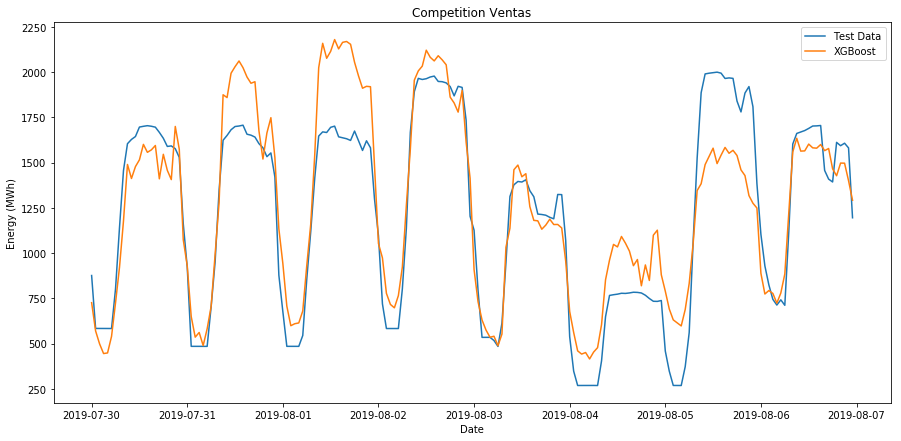

<Figure size 1080x720 with 0 Axes>

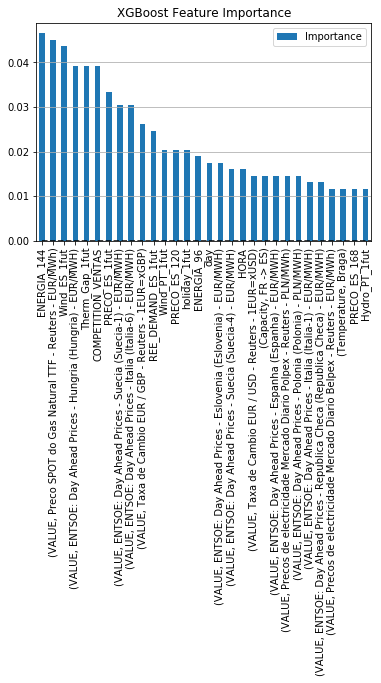

In [6]:
# Visualize Results
print('\n', 'mean_absolute_percentage_error', MAP_error1, '\n')

# Test vs Actual
plt.figure(figsize=(15, 7))

plt.plot(combined, y_test1)
plt.plot(combined, predicted1)
plt.legend(['Test Data', 'XGBoost'])
plt.title('Competition Ventas')
plt.ylabel('Energy (MWh)')
plt.xlabel('Date')

# Feature Importance
n=30
plt.figure(figsize=(15, 10))
feature_imp_df.head(n).plot(kind='bar')
plt.grid(True, axis='y')
plt.hlines(y=0, xmin=0, xmax=n, linestyles='dashed')
plt.title('XGBoost Feature Importance');


In [7]:
# Remove Least Used Features
a = feature_imp_df<= 0.005
b = a[a.Importance==True]
dropvariables = b.index
df=df.drop(df[dropvariables],axis=1)

train = df[(df.date >= first_train_date) & (df.date <= last_train_date)].drop(['DATA'],1)

train = train.fillna(method='ffill')
train = train.fillna(train.mean())

df_test = df
df_test = df_test.fillna(method='ffill')
df_test = df_test.fillna(df_test.mean())

test = df_test[(df_test.date >= pred_date_START) & (df_test.date <= pred_date_END)].drop(['DATA'],1)

prediction_set =  df_test[(df_test.date >= pred_date_END+timedelta(1)) & (df_test.date <= pred_date_END+timedelta(1))].drop(['DATA'],1)


train = train.reset_index(drop=True)
test = test.reset_index(drop=True)
prediction_set=prediction_set.reset_index(drop=True)


X_test, y_test = [test.drop(['date', 'COMPETITION_VENTAS_1fut'],1), test['COMPETITION_VENTAS_1fut']]
X_pred = prediction_set.drop(['date', 'COMPETITION_VENTAS_1fut'],1)

X_train, y_train = [train.drop(['date', 'COMPETITION_VENTAS_1fut'],1), train['COMPETITION_VENTAS_1fut']]

# Normalze variables, Final Preprocessing Step, needed for Neural Networks
# we create sets x_train_c, x_test_c, and x_pred_c by copying X_train and X_test and then normalizing the copies.

x_train_c= deepcopy(X_train)
x_test_c = deepcopy(X_test)
x_pred_c = deepcopy(X_pred)

from sklearn import preprocessing

# Normalize Training Data 
train_norm = x_train_c[x_train_c.columns[:]]
test_norm = x_test_c[x_test_c.columns[:]]
pred_norm = x_pred_c[x_pred_c.columns[:]]

std_scale = preprocessing.StandardScaler().fit(train_norm)
x_train_norm = std_scale.transform(train_norm)
#Converting numpy array to dataframe
training_norm_col = pd.DataFrame(x_train_norm, index=train_norm.index, columns=train_norm.columns) 
x_train_c.update(training_norm_col)

# Normalize Testing Data by using mean and SD of training set
x_test_norm = std_scale.transform(test_norm)
testing_norm_col = pd.DataFrame(x_test_norm, index=test_norm.index, columns=test_norm.columns) 
x_test_c.update(testing_norm_col)

# Normalize Prediction Data by using mean and SD of training set
x_pred_norm = std_scale.transform(pred_norm)
pred_norm_col = pd.DataFrame(x_pred_norm, index=pred_norm.index, columns=pred_norm.columns) 
x_pred_c.update(pred_norm_col)


C:\Users\e351722\AppData\Local\Continuum\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\e351722\AppData\Local\Continuum\anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:46: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
C:\Users\e351722\AppData\Local\Continuum\anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:52: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
C:\Users\e351722\AppData\Local\Continuum\anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:57: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.


Train on 2712 samples, validate on 192 samples
Epoch 1/100
2712/2712 [==============================] - 0s 125us/step - loss: 99.5528 - mean_absolute_percentage_error: 99.5528 - val_loss: 99.8744 - val_mean_absolute_percentage_error: 99.8744
Epoch 2/100
2712/2712 [==============================] - 0s 38us/step - loss: 96.7683 - mean_absolute_percentage_error: 96.7683 - val_loss: 99.5575 - val_mean_absolute_percentage_error: 99.5575
Epoch 3/100
2712/2712 [==============================] - 0s 37us/step - loss: 90.0252 - mean_absolute_percentage_error: 90.0252 - val_loss: 99.1427 - val_mean_absolute_percentage_error: 99.1427
Epoch 4/100
2712/2712 [==============================] - 0s 37us/step - loss: 86.9694 - mean_absolute_percentage_error: 86.9694 - val_loss: 99.1226 - val_mean_absolute_percentage_error: 99.1226
Epoch 5/100
2712/2712 [==============================] - 0s 37us/step - loss: 85.1954 - mean_absolute_percentage_error: 85.1954 - val_loss: 98.8755 - val_mean_absolute_percenta

Epoch 43/100
2712/2712 [==============================] - 0s 37us/step - loss: 34.6182 - mean_absolute_percentage_error: 34.6182 - val_loss: 40.0154 - val_mean_absolute_percentage_error: 40.0154
Epoch 44/100
2712/2712 [==============================] - 0s 36us/step - loss: 33.7230 - mean_absolute_percentage_error: 33.7230 - val_loss: 41.5086 - val_mean_absolute_percentage_error: 41.5086
Epoch 45/100
2712/2712 [==============================] - 0s 35us/step - loss: 32.9466 - mean_absolute_percentage_error: 32.9466 - val_loss: 43.0757 - val_mean_absolute_percentage_error: 43.0757
Epoch 46/100
2712/2712 [==============================] - 0s 35us/step - loss: 32.2748 - mean_absolute_percentage_error: 32.2748 - val_loss: 43.9315 - val_mean_absolute_percentage_error: 43.9315
Epoch 47/100
2712/2712 [==============================] - 0s 35us/step - loss: 31.6394 - mean_absolute_percentage_error: 31.6394 - val_loss: 45.3517 - val_mean_absolute_percentage_error: 45.3517
Epoch 48/100
2712/2712 [=

2712/2712 [==============================] - 0s 41us/step - loss: 22.5677 - mean_absolute_percentage_error: 22.5677 - val_loss: 59.5207 - val_mean_absolute_percentage_error: 59.5207
Epoch 86/100
2712/2712 [==============================] - 0s 37us/step - loss: 22.5289 - mean_absolute_percentage_error: 22.5289 - val_loss: 59.2051 - val_mean_absolute_percentage_error: 59.2051
Epoch 87/100
2712/2712 [==============================] - 0s 37us/step - loss: 22.3475 - mean_absolute_percentage_error: 22.3475 - val_loss: 59.6839 - val_mean_absolute_percentage_error: 59.6839
Epoch 88/100
2712/2712 [==============================] - 0s 37us/step - loss: 22.2090 - mean_absolute_percentage_error: 22.2090 - val_loss: 58.4866 - val_mean_absolute_percentage_error: 58.4866
Epoch 89/100
2712/2712 [==============================] - 0s 36us/step - loss: 22.0471 - mean_absolute_percentage_error: 22.0471 - val_loss: 58.5579 - val_mean_absolute_percentage_error: 58.5579
Epoch 90/100
2712/2712 [==============

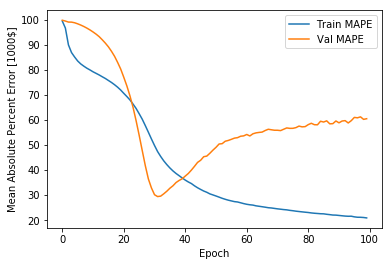

<Figure size 432x288 with 0 Axes>

In [9]:
def keras_dnn(x_train, y_train, x_test, y_test):

    '''Using normalized data to predict day ahead prices'''
    import pandas as pd
    #from sklearn.cross_validation import train_test_split
    from IPython import display
    from matplotlib import cm
    from matplotlib import gridspec
    from matplotlib import pyplot as plt
    import numpy as np
    import pandas as pd
    from sklearn import metrics
    import tensorflow as tf
    from tensorflow.python.data import Dataset
    import keras
    from keras.utils import to_categorical
    from keras import models
    from keras import layers
    import math
    import matplotlib.pyplot as plt
    #df = pd.read_csv('covtype.csv')


    hl_scaling = 4
    input_layer = np.shape(x_train)[1]
    output_layer = 1
    middle_hidden_layer = round((np.shape(x_train)[0])/(hl_scaling*(np.shape(x_train)[1]+output_layer)))

    #x_train, x_test, y_train, y_test = train_test_split(x, y , train_size = 0.7, random_state =  90)
    #'''As y variable is multi class categorical variable, hence using softmax as activation function and sparse-categorical cross entropy as loss function.'''
    model = keras.Sequential([
     keras.layers.Dense(input_layer, kernel_initializer='normal', activation=tf.nn.relu,                  
     input_shape=(x_train.shape[1],)),
   #  keras.layers.Dropout(0.8, noise_shape=None, seed=None),

     keras.layers.Dense(middle_hidden_layer,  kernel_initializer='normal', activation=tf.nn.relu),
 #    keras.layers.Dropout(0.8, noise_shape=None, seed=None),
  #   keras.layers.Dense(round(middle_hidden_layer/2),  kernel_initializer='normal', activation=tf.nn.relu),
        
  #   keras.layers.Dense(round(middle_hidden_layer/4),  kernel_initializer='normal', activation=tf.nn.relu),

     keras.layers.Dense(output_layer, activation='linear'),


     #keras.layers.Dense(1, activation=  'softmax')
     ])
    
    model.compile(optimizer='adam',
              loss='mean_absolute_percentage_error',
              metrics=['mean_absolute_percentage_error'])
    history1 = model.fit(
     x_train, y_train,
     epochs= 100, batch_size = 100,
     validation_data = (x_test, y_test))

    return history1, model

#make plots
def plot_history(history1):
 plt.figure()
 plt.xlabel('Epoch')
 plt.ylabel('Mean Absolute Percent Error [1000$]')
 plt.plot(history1.epoch, np.array(history1.history['mean_absolute_percentage_error']),
 label='Train MAPE')
 plt.plot(history1.epoch, np.array(history1.history['val_mean_absolute_percentage_error']),
 label = 'Val MAPE')
 plt.legend()

[history1, model] = keras_dnn(x_train_c, y_train, x_test_c, y_test)

plot_history(history1)

# Plot Back-testing prediction
predictedkeras = model.predict(x_test_c)
plt.figure()

MAP_error3 = mean_absolute_percentage_error(predictedkeras.flatten(), y_test)


#plt.plot(ynew)
#plt.plot(y_test.reset_index(drop=True))
#plt.show()

#plt.figure()
#plt.scatter(y_test,pd.DataFrame(ynew))
#max_x = max(y_test)
#min_x = min(y_test)
#max_y = max(ynew)
#min_y = min(ynew)
#plt.xlim(min_x, max_x)
#plt.ylim(min_y, max_y)
#plt.plot([min_x, max_x], [min_x, max_x], 'k--')
#plt.show()

print('\n', 'mean_absolute_percentage_error', MAP_error3, '\n')

lstm_prediction = model.predict(x_pred_c.tail(24)).flatten()
#plt.figure()
#plt.plot(tree5_prediction.flatten())
#plt.show()


In [10]:
# # Train Lasso Regression Model 

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LassoCV


from sklearn.model_selection import TimeSeriesSplit # you have everything done for you

# for time-series cross-validation set 5 folds 
tscv = TimeSeriesSplit(n_splits=5)

# Train Model
lasso = LassoCV(cv=tscv)
lasso.fit(x_train_c, y_train)


# Make forward prediction
lass_test = lasso.predict(x_test_c)
lasso_prediction = lasso.predict(x_pred_c)
MAP_error_lasso = mean_absolute_percentage_error(lass_test, y_test)

print('\n', 'mean_absolute_percentage_error', MAP_error_lasso, '\n')


C:\Users\e351722\AppData\Local\Continuum\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\e351722\AppData\Local\Continuum\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\e351722\AppData\Local\Continuum\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\e351722\AppData\Local\Continuum\anaconda


 mean_absolute_percentage_error 21.190747062497948 



C:\Users\e351722\AppData\Local\Continuum\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\e351722\AppData\Local\Continuum\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\e351722\AppData\Local\Continuum\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\e351722\AppData\Local\Continuum\anaconda

C:\Users\e351722\AppData\Local\Continuum\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\e351722\AppData\Local\Continuum\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\e351722\AppData\Local\Continuum\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\e351722\AppData\Local\Continuum\anaconda

C:\Users\e351722\AppData\Local\Continuum\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\e351722\AppData\Local\Continuum\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\e351722\AppData\Local\Continuum\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\e351722\AppData\Local\Continuum\anaconda

C:\Users\e351722\AppData\Local\Continuum\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\e351722\AppData\Local\Continuum\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\e351722\AppData\Local\Continuum\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\e351722\AppData\Local\Continuum\anaconda

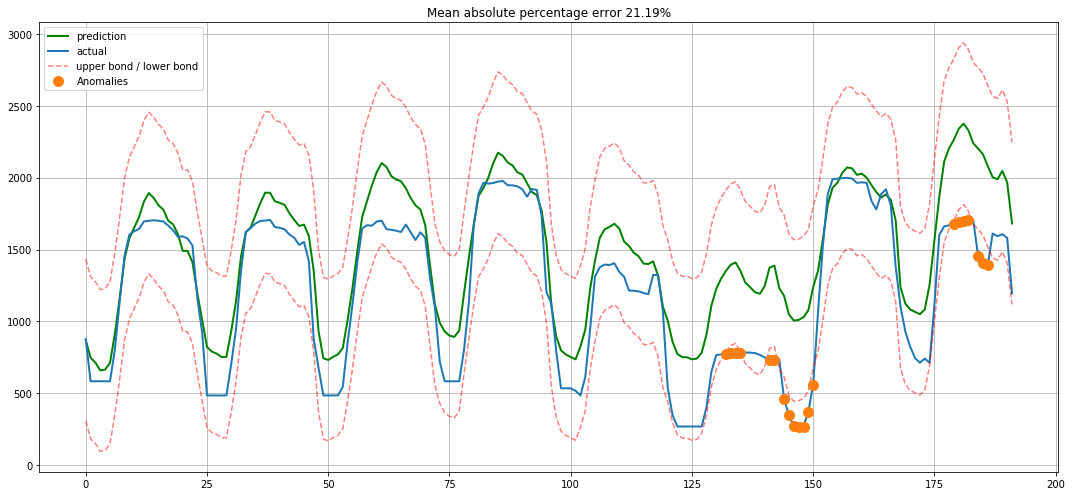

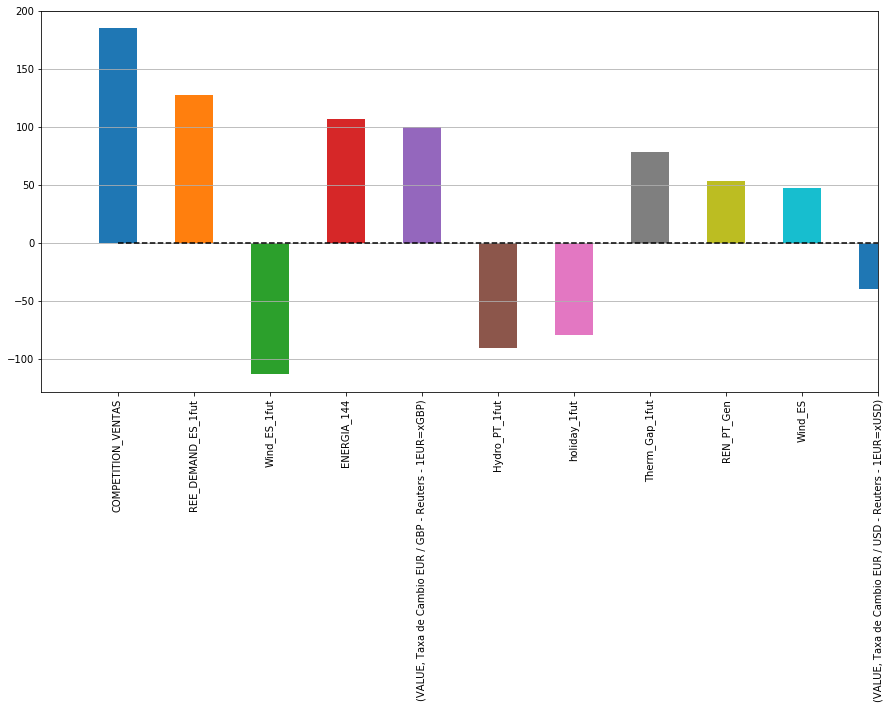

In [11]:
# Visualize Results 

# Define Plot Makers

def plotModelResults(model, X_train=X_train, X_test=X_test, plot_intervals=False, plot_anomalies=False):
    """
        Plots modelled vs fact values, prediction intervals and anomalies
    
    """
    
    prediction = model.predict(X_test)
    
    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)
    
    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train, 
                                    cv=tscv, 
                                    scoring="neg_mean_absolute_error")
        mae = cv.mean() * (-1)
        deviation = cv.std()
        
        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)
        
        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)
        
        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    error = mean_absolute_percentage_error(prediction, y_test)
    plt.title("Mean absolute percentage error {0:.2f}%".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);
    
def plotCoefficients(model):
    """
        Plots sorted coefficient values of the model
    """
    
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=10, linestyles='dashed')
    plt.xlim([-1, 10])
    plt.show();



# Call Plot makers
plotModelResults(lasso, 
                 X_train=x_train_c, 
                 X_test=x_test_c, 
                 plot_intervals=True, plot_anomalies=True)

plotCoefficients(lasso)


In [12]:


model_1_map = MAP_error1
model_2_map = MAP_error_lasso
model_3_map = MAP_error3


models_list = [model_1_map, model_2_map, model_3_map]
minIndex = models_list.index(min(models_list))
minIndex

models_output = np.array([list(tree1_prediction), 
                          list(lasso_prediction),
                          list(lstm_prediction)
                                 ])

model_names = np.array(['XGB', 'Lasso', 'LSTM'])


import csv 
import datetime
now = datetime.datetime.now()

prediction_date_vector = pred_date_END+timedelta(2)
prediction_date_vector = prediction_date_vector.strftime('%Y-%m-%d')


DATA = pd.DataFrame([prediction_date_vector]*24, columns = ['DATA'])

HOURS = pd.DataFrame(list(range(1,25)), columns = ['Hour'])

csvfile_top = pd.DataFrame(list(models_output[minIndex,:]), columns = ['Best:' +model_names[minIndex]])

csvfile_1 = pd.DataFrame(list(tree1_prediction), columns = ['XGB'])

csvfile_2 = pd.DataFrame(list(lasso_prediction), columns = ['Lasso'])

csvfile_3 = pd.DataFrame(list(lstm_prediction), columns = ['KR-LSTM'])


cvfileall = pd.concat([DATA, HOURS, csvfile_top, csvfile_1, csvfile_2, csvfile_3], axis = 1)

test_date = pred_date_END+timedelta(1)
test_date = test_date.strftime('%Y%m%d')

prediction_date = pred_date_END+timedelta(2)
prediction_date = prediction_date.strftime('%Y%m%d')

cvfileall.to_excel('C:/Users/e351722/OneDrive - EDP/Competition/results/PBCVENTAS_'+'_'+prediction_date+'.xlsx', sheet_name='sheet1', index=False)



In [15]:
PREDDATE = pd.DataFrame([now.strftime("%Y-%m-%dT%H:%M:%S")]*24, columns = ['DATA'])
tdmi = pd.DataFrame({'Forecast Datetime': PREDDATE.DATA})
tdmi['Market Date'] = DATA
tdmi['Market hour'] = HOURS-1
tdmi['Variable'] = pd.DataFrame(['PBC-VENTAS']*24)
tdmi['Model'] = pd.DataFrame(['XGB']*24)
tdmi['Value'] =  csvfile_1
tdmi = tdmi.applymap(str)
tdmi

,Forecast Datetime,Market Date,Market hour,Variable,Model,Value
0,2019-08-06T10:24:55,2019-08-07,0,PBC-VENTAS,XGB,924.910888671875
1,2019-08-06T10:24:55,2019-08-07,1,PBC-VENTAS,XGB,705.4151611328125
2,2019-08-06T10:24:55,2019-08-07,2,PBC-VENTAS,XGB,715.0658569335938
3,2019-08-06T10:24:55,2019-08-07,3,PBC-VENTAS,XGB,653.6148681640625
4,2019-08-06T10:24:55,2019-08-07,4,PBC-VENTAS,XGB,650.0181274414062
5,2019-08-06T10:24:55,2019-08-07,5,PBC-VENTAS,XGB,746.9354858398438
6,2019-08-06T10:24:55,2019-08-07,6,PBC-VENTAS,XGB,763.0980834960938
7,2019-08-06T10:24:55,2019-08-07,7,PBC-VENTAS,XGB,1081.22021484375
8,2019-08-06T10:24:55,2019-08-07,8,PBC-VENTAS,XGB,1447.68603515625
9,2019-08-06T10:24:55,2019-08-07,9,PBC-VENTAS,XGB,1460.5699462890625


In [16]:
dataframe_output = pd.DataFrame({'forecastData': tdmi.to_dict('records')})
dataframe_output2 = pd.DataFrame({'Request': dataframe_output.to_dict('list')})

json_out = dataframe_output2.to_dict('dict')


In [17]:
import json
with open(r'C:/Users/e351722/OneDrive - EDP/Competition/results/TDMI_'+'_'+prediction_date+'.json', 'w') as outfile:
    json.dump(json_out, outfile, indent=4)

In [18]:
#json_out.to_json(r'C:/Users/e351722/OneDrive - EDP/Competition/results/TDMI_'+'_'+prediction_date+'.json')
#tdmi.to_excel('C:/Users/e351722/OneDrive - EDP/Competition/results/TDMI_'+'_'+prediction_date+'.xlsx', sheet_name='sheet1', index=False)


Text(0.5, 0, 'Date')

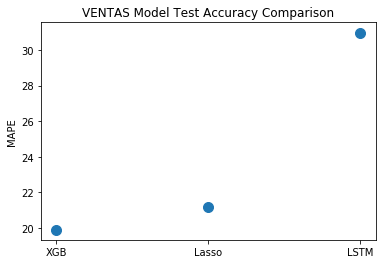

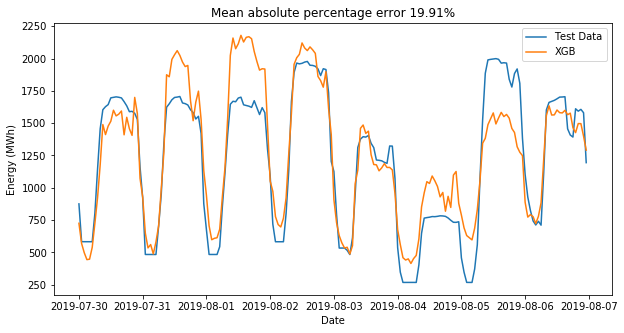

In [19]:
plt.figure()
plt.scatter(model_names, models_list, marker = 'o', s = 100)
plt.ylabel('MAPE')
plt.title('VENTAS Model Test Accuracy Comparison')


# Test vs Actual

models_test = np.array([list(predicted1), 
                          list(lass_test),
                          list(predictedkeras)
                                 ])

plt.figure(figsize=(10, 5))

plt.plot(combined, y_test1)
plt.plot(combined, list(models_test[minIndex,:]))
plt.legend(['Test Data',model_names[minIndex]])
plt.title("Mean absolute percentage error {0:.2f}%".format(models_list[minIndex]))
plt.ylabel('Energy (MWh)')
plt.xlabel('Date')